Simulating 1000 Tetris games...
Extracting features...
Extracted 42007 samples.
Label distribution:
 label
bad move     38955
good move     3052
Name: count, dtype: int64
Training model...
Classification Report:
               precision    recall  f1-score   support

    bad move       0.94      0.98      0.96      7807
   good move       0.35      0.15      0.21       595

    accuracy                           0.92      8402
   macro avg       0.64      0.56      0.58      8402
weighted avg       0.90      0.92      0.90      8402

Confusion Matrix:
 [[7638  169]
 [ 505   90]]
Accuracy: 0.9197810045227327
Precision: 0.3474903474903475
Recall: 0.15126050420168066
F1 Score: 0.2107728337236534
ROC AUC Score: 0.6788234648284829


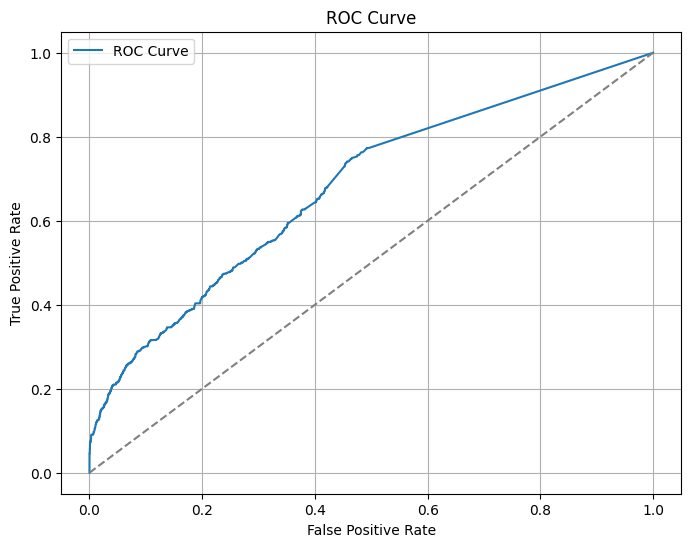

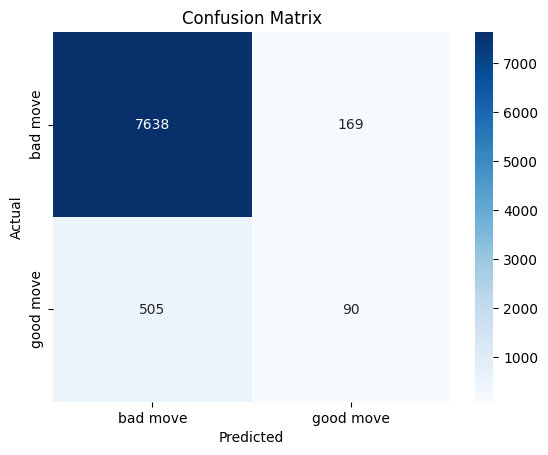

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import copy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, accuracy_score, precision_score, recall_score, f1_score
)

SHAPES = {
    'I': np.array([[1, 1, 1, 1]]),
    'O': np.array([[1, 1], [1, 1]]),
    'T': np.array([[0, 1, 0], [1, 1, 1]]),
    'S': np.array([[0, 1, 1], [1, 1, 0]]),
    'Z': np.array([[1, 1, 0], [0, 1, 1]]),
    'J': np.array([[1, 0, 0], [1, 1, 1]]),
    'L': np.array([[0, 0, 1], [1, 1, 1]])
}

class TetrisBoard:
    def __init__(self, rows=20, cols=10):
        self.rows = rows
        self.cols = cols
        self.board = np.zeros((rows, cols), dtype=int)
        self.score = 0
        self.total_lines_cleared = 0

    def can_place(self, piece, row, col):
        for r in range(piece.shape[0]):
            for c in range(piece.shape[1]):
                if piece[r, c] == 1:
                    if (row + r >= self.rows or col + c < 0 or col + c >= self.cols or self.board[row + r, col + c] == 1):
                        return False
        return True

    def place_piece(self, piece, row, col):
        for r in range(piece.shape[0]):
            for c in range(piece.shape[1]):
                if piece[r, c] == 1:
                    self.board[row + r, col + c] = 1

    def clear_lines(self):
        lines_cleared = 0
        new_board = []
        for row in self.board:
            if np.all(row == 1):
                lines_cleared += 1
            else:
                new_board.append(row)
        for _ in range(lines_cleared):
            new_board.insert(0, np.zeros(self.cols, dtype=int))
        self.board = np.array(new_board)
        self.total_lines_cleared += lines_cleared
        return lines_cleared

    def update_score(self, lines_cleared):
        scoring = {0: 0, 1: 100, 2: 300, 3: 500, 4: 800}
        self.score += scoring.get(lines_cleared, 0)

    def evaluate_board(self):
        heights = np.argmax(self.board[::-1] > 0, axis=0)
        heights = np.where(np.all(self.board == 0, axis=0), 0, self.rows - heights)
        aggregate_height = np.sum(heights)
        bumpiness = np.sum(np.abs(np.diff(heights)))
        holes = 0
        max_height = np.max(heights)
        depth_above_holes = 0

        for c in range(self.cols):
            block_found = False
            hole_depth = 0
            for r in range(self.rows):
                if self.board[r][c] == 1:
                    block_found = True
                elif block_found and self.board[r][c] == 0:
                    holes += 1
                    hole_depth += 1
            depth_above_holes += hole_depth

        return aggregate_height, bumpiness, holes, max_height, depth_above_holes

    def simulate_best_move(self, piece_type):
        best_score = -float('inf')
        best_state = None
        piece = SHAPES[piece_type]
        seen_configs = set()

        for rot in range(4):
            rotated = np.rot90(piece, rot)
            config_hash = rotated.tobytes()
            if config_hash in seen_configs:
                continue
            seen_configs.add(config_hash)

            for col in range(self.cols - rotated.shape[1] + 1):
                temp_board = copy.deepcopy(self)
                row = 0
                while temp_board.can_place(rotated, row, col):
                    row += 1
                row -= 1
                if row < 0:
                    continue
                temp_board.place_piece(rotated, row, col)
                lines = temp_board.clear_lines()
                agg_h, bump, holes, max_h, depth_above_holes = temp_board.evaluate_board()

                score = (
                    lines * 1200
                    - agg_h * 0.4
                    - holes * 15.0
                    - bump * 3.0
                    - max_h * 0.5
                    - depth_above_holes * 0.1
                    + (self.rows - row) * 0.1
                )

                bottom_row_fill = np.sum(temp_board.board[-1])
                if bottom_row_fill >= self.cols - 2:
                    score += 50

                if score > best_score:
                    best_score = score
                    best_state = {
                        'rotation_index': rot,
                        'x_pos': col,
                        'y_pos': row,
                        'lines_cleared': lines,
                        'score': temp_board.score,
                        'board': copy.deepcopy(temp_board.board),
                        'depth_above_holes': depth_above_holes
                    }

        if best_state:
            final_piece = np.rot90(SHAPES[piece_type], best_state['rotation_index'])
            if not self.can_place(final_piece, best_state['y_pos'], best_state['x_pos']):
                return None
            self.place_piece(final_piece, best_state['y_pos'], best_state['x_pos'])
            lines = self.clear_lines()
            self.update_score(lines)
            return {
                'piece_type': piece_type,
                'rotation_index': best_state['rotation_index'],
                'x_pos': best_state['x_pos'],
                'y_pos': best_state['y_pos'],
                'lines_cleared': lines,
                'score': self.score,
                'depth_above_holes': best_state['depth_above_holes']
            }
        return None

def simulate_n_games(n_games=1000):
    logs = []
    for _ in range(n_games):
        board = TetrisBoard()
        for piece_count in range(200):
            piece = random.choice(list(SHAPES.keys()))
            move = board.simulate_best_move(piece)
            if move:
                label = 'good move' if move['lines_cleared'] > 0 else 'bad move'
                agg_h, bump, holes, max_h, depth_above_holes = board.evaluate_board()
                logs.append({
                    **move,
                    'aggregate_height': agg_h,
                    'bumpiness': bump,
                    'holes': holes,
                    'max_height': max_h,
                    'depth_above_holes': depth_above_holes,
                    'pieces_dropped': piece_count + 1,
                    'label': label
                })
            else:
                break
    return logs

def extract_features_and_label(logs):
    df = pd.DataFrame(logs)
    features = ['aggregate_height', 'bumpiness', 'holes', 'max_height', 'depth_above_holes', 'pieces_dropped']
    df = df[features + ['label']]
    return df

def train_and_evaluate_model(df):
    X = df.drop('label', axis=1)
    y = df['label']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, list(model.classes_).index('good move')]

    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=model.classes_))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=model.classes_))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, pos_label='good move'))
    print("Recall:", recall_score(y_test, y_pred, pos_label='good move'))
    print("F1 Score:", f1_score(y_test, y_pred, pos_label='good move'))
    print("ROC AUC Score:", roc_auc_score((y_test == 'good move').astype(int), y_proba))

    fpr, tpr, _ = roc_curve((y_test == 'good move').astype(int), y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return model, scaler

if __name__ == "__main__":
    print("Simulating 1000 Tetris games...")
    logs = simulate_n_games(1000)
    print("Extracting features...")
    df = extract_features_and_label(logs)
    print(f"Extracted {len(df)} samples.")
    print("Label distribution:\n", df['label'].value_counts())
    print("Training model...")
    model, scaler = train_and_evaluate_model(df)
